In [19]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, chisquare
import warnings
warnings.filterwarnings('ignore')

An e-commerce company has launched a new web page aimed at increasing user conversions, i.e., the number of visitors who choose to purchase the company's product. Our objective is to analyze the results of an A/B test conducted on the website and provide recommendations based on the findings.


## Treatment Group vs. Control Group in A/B Testing  

In **A/B testing**, users are randomly assigned to one of two groups:  

- **Control Group** 🟢: Sees the **current version** of a webpage, app, or feature. It serves as a **reference point**.  
- **Treatment Group** 🔵: Sees the **new version**, which includes a change the company wants to evaluate.  

### Example Dataset  

| id      | con_treat  | page      | converted |
|---------|-----------|-----------|-----------|
| 851104  | control   | old_page  | 0         |
| 804228  | control   | old_page  | 0         |
| 661590  | treatment | new_page  | 0         |
| 853541  | treatment | new_page  | 0         |
| 864975  | control   | old_page  | 1         |

- **Control Group (`control`)** → sees the **old page** (`old_page`).  
- **Treatment Group (`treatment`)** → sees the **new page** (`new_page`).  
- **Column `converted`**: Indicates whether a user made a purchase (`1 = conversion`, `0 = no conversion`).  

### Goal of A/B Testing  
Compare conversion rates between the two groups:  
- If the **new page** leads to **higher conversions**, it may be adopted.  
- If the **difference is small** or the new page **performs worse**, the old version should be kept.  


In [20]:
# importing data
abtest = pd.read_csv('ab_test.csv')
country_test=pd.read_csv('countries_ab.csv')

In [21]:
# overview and check for null values of abtest data
print(abtest.head())
print('\n')
print(abtest.info())

       id     time  con_treat      page  converted
0  851104  11:48.6    control  old_page          0
1  804228  01:45.2    control  old_page          0
2  661590  55:06.2  treatment  new_page          0
3  853541  28:03.1  treatment  new_page          0
4  864975  52:26.2    control  old_page          1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         294478 non-null  int64 
 1   time       294478 non-null  object
 2   con_treat  294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None


In [22]:
# convert time to a datetime object

abtest['time'] = pd.to_datetime(abtest['time'],format='%M:%S.%f')

print(abtest)
print(abtest.dtypes)

            id                    time  con_treat      page  converted
0       851104 1900-01-01 00:11:48.600    control  old_page          0
1       804228 1900-01-01 00:01:45.200    control  old_page          0
2       661590 1900-01-01 00:55:06.200  treatment  new_page          0
3       853541 1900-01-01 00:28:03.100  treatment  new_page          0
4       864975 1900-01-01 00:52:26.200    control  old_page          1
...        ...                     ...        ...       ...        ...
294473  751197 1900-01-01 00:28:38.600    control  old_page          0
294474  945152 1900-01-01 00:51:57.100    control  old_page          0
294475  734608 1900-01-01 00:45:03.400    control  old_page          0
294476  697314 1900-01-01 00:20:29.000    control  old_page          0
294477  715931 1900-01-01 00:40:24.500  treatment  new_page          0

[294478 rows x 5 columns]
id                    int64
time         datetime64[ns]
con_treat            object
page                 object
converted

In [24]:
# check the proportion of old_page and new_page categories in 'page' column
print(abtest['page'].value_counts(normalize=True))


page
old_page    0.5
new_page    0.5
Name: proportion, dtype: float64


In [ ]:
# check the proportion of control and treatment categories in 'con_treat' column - it's not even
print(abtest['con_treat'].value_counts(normalize=True))


con_treat
treatment    0.500126
control      0.499874
Name: proportion, dtype: float64


In [27]:
# check the proportion of group categories who experienced new_page or old_page.
abtest.groupby('page')['con_treat'].value_counts(normalize=True)

page      con_treat
new_page  treatment    0.986906
          control      0.013094
old_page  control      0.986654
          treatment    0.013346
Name: proportion, dtype: float64

Just 1% of control group has seen the new_page while 1% of treatement group has seen old_page

In [28]:
# check the unicity of the customers
all_id_vals = len(abtest['id'])
uniq_id_vals = abtest['id'].nunique()
nonuniq_id_vals = all_id_vals - uniq_id_vals
print(nonuniq_id_vals)


3894


there is 3894 users which belong to the two group.

In [29]:
# select duplicated ids rows in another df
duplic_ids = abtest[abtest.duplicated(subset='id', keep=False)].reset_index(drop=True)
print(duplic_ids.sort_values(by=['id']).head(10))

          id                    time  con_treat      page  converted
6051  630052 1900-01-01 00:16:05.200  treatment  new_page          0
5597  630052 1900-01-01 00:25:54.100  treatment  old_page          1
591   630126 1900-01-01 00:35:54.800  treatment  old_page          0
6610  630126 1900-01-01 00:16:00.300  treatment  new_page          0
4843  630137 1900-01-01 00:08:49.900    control  old_page          0
322   630137 1900-01-01 00:59:22.100    control  new_page          0
5439  630320 1900-01-01 00:02:43.600    control  old_page          0
6718  630320 1900-01-01 00:27:37.200  treatment  old_page          0
2524  630471 1900-01-01 00:14:17.400    control  new_page          0
2920  630471 1900-01-01 00:42:51.500    control  old_page          0


we grouped the duplicated ids by ids. and we observe that there were users that were experienced both the old and the  new pages. We need two independent groups to avoid biases due to contamination.

In [30]:
# drop duplicates from 'id' column
abtestunique = abtest.drop_duplicates(subset='id', keep=False)

In [31]:
# check the proportion for control - old_page and treatment - new_page categories after dropping duplicates
abtestunique.groupby('con_treat')['page'].value_counts(normalize=True)

con_treat  page    
control    old_page    1.0
treatment  new_page    1.0
Name: proportion, dtype: float64

In [32]:
# check the proportion of control\treatment groups
abtestunique['con_treat'].value_counts()

con_treat
treatment    143397
control      143293
Name: count, dtype: int64

In [33]:
# conduct chi-square goodness of fit test to exclude SRM.
chisquare(f_obs=[143397,143293], f_exp=[(143397+143293)/2,(143397+143293)/2])


Power_divergenceResult(statistic=0.037727161742648854, pvalue=0.8459920267710567)

since 0.85 > 0.05 we can conclude by using the chi_square goodness of fit that there is a good repartition of the users among the two groups (50/50). 

## II. Analysis of cleaned data

In [34]:
# looking for counts of conversions in groups
abtestunique.groupby('converted')['con_treat'].value_counts()

converted  con_treat
0          treatment    126372
           control      126073
1          control       17220
           treatment     17025
Name: count, dtype: int64

the control group make more conversion that the treatment group

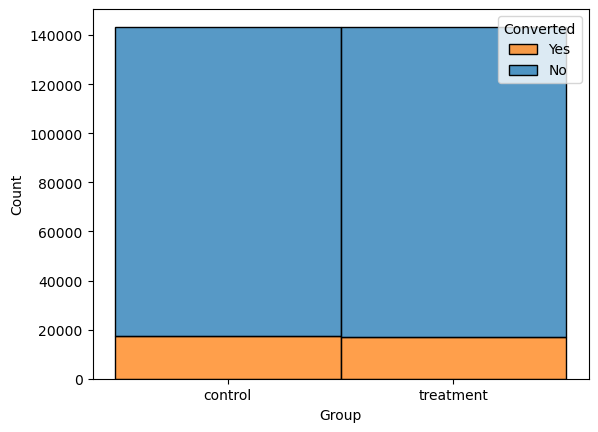

In [35]:
# making a histogram to compare converted\non-converted between groups
sns.histplot(data=abtestunique, x='con_treat', hue='converted', multiple='stack')
plt.xlabel('Group')
plt.legend(['Yes', 'No'], title='Converted')
plt.show()

In [36]:
# comparing conv. rates between groups and calculating % of difference between them
control = abtestunique[abtestunique['con_treat'] == 'control']['converted']
treatment = abtestunique[abtestunique['con_treat'] == 'treatment']['converted']

control_conv = np.mean(control)
treatment_conv = np.mean(treatment)

print(f'Conversion rate of control group is {round(control_conv,3)}')
print(f'Conversion rate of treatment group is {round(treatment_conv,3)}')


Conversion rate of control group is 0.12
Conversion rate of treatment group is 0.119


The calculation shows that the conversion rate of the two groups is almost identical. Now, we need to check the **statistical significance**.  

- **Null Hypothesis (H₀):** There is no significant difference in conversion rate between the two groups.  
- **Alternative Hypothesis (H₁):** The conversion rate of the treatment group is higher or lower (two-sided).  
- **Significance Level (α):** 0.05.  

In [37]:
# check p_value for difference in groups with ttest_ind
ttest_ind(control, treatment)

TtestResult(statistic=1.1944838871517813, pvalue=0.23228972812920373, df=286688.0)

In [39]:
# check p_value for difference in converted between two groups in abtestunique with proportions ztest 
# (alternative two-sided)
stat, p_value = proportions_ztest(count=[17220, 17025], nobs=[17220+126073, 17025+126372])
print(stat, p_value)

1.1944850812796501 0.23228827305833621


Since **0.23 > 0.05**, we **fail to reject the null hypothesis**, meaning there is **no statistically significant difference** between the two groups.  

- Both the **T-test** and **Proportions Z-test** confirmed that we cannot reject the null hypothesis.  
- **Conclusion:** There is no significant difference in conversion rates between the two groups.  

Next, let’s analyze the conversion rates **by country** to check for variations across different regions.  

In [40]:
print(country_test.head(6))
print('\n')
print(country_test.info())

       id country
0  834778      UK
1  928468      US
2  822059      UK
3  711597      UK
4  710616      UK
5  909908      UK


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       290584 non-null  int64 
 1   country  290584 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB
None


In [41]:
# look at the proportion of values in country groups
country_test['country'].value_counts(normalize=True)

country
US    0.700723
UK    0.249381
CA    0.049896
Name: proportion, dtype: float64

In [42]:
# merging abtestunique and countries data
abtestunco = abtestunique.merge(country_test, on='id', how='left')


In [26]:
# looking at values of converted distributed by countries and groups
abtestunco.groupby(['country', 'con_treat'])['converted'].value_counts()

country  con_treat  converted
CA       control    0             6250
                    1              844
         treatment  0             6399
                    1              810
UK       control    0            31588
                    1             4295
         treatment  0            31313
                    1             4317
US       control    0            88235
                    1            12081
         treatment  0            88660
                    1            11898
Name: count, dtype: int64

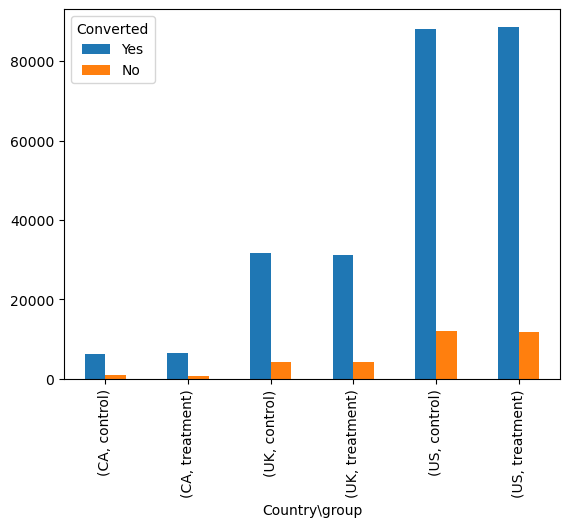

In [43]:
# plotting converted\non-cnverted by countries\groups
ab = abtestunco.groupby(['country', 'con_treat'])['converted'].value_counts()
abdf = pd.DataFrame(ab)
abdf.rename(columns={'converted':'number'}, inplace=True)
abdf = abdf.unstack()
abdf.plot(kind='bar')
plt.legend(['Yes', 'No'], title='Converted')
plt.xlabel('Country\group')
plt.show()


In [ ]:
# Check p-value for difference in conversion rates between two groups (Canada)

converted = [844, 810]       # Number of conversions in each group
observations = [844+6250, 810+6399]  # Total observations in each group

# Perform two-proportion z-test
# Alternative hypothesis: two-sided (conversion rates are not equal)
z_stat, p_value = proportions_ztest(count=converted, nobs=observations, alternative='two-sided')

# Print results with interpretation
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Result: Statistically significant difference (reject null hypothesis)")
else:
    print("Result: No statistically significant difference (fail to reject null hypothesis)")



Z-statistic: 1.2367
P-value: 0.2162
Result: No statistically significant difference (fail to reject null hypothesis)


In [ ]:
# check p_value for difference in converted between two groups for UK

converted = [4295, 4317]       # Number of conversions in each group
observations = [4295+31588, 4317+31313]  # Total observations in each group

# Perform two-proportion z-test
# Alternative hypothesis: two-sided (conversion rates are not equal)
z_stat, p_value = proportions_ztest(count=converted, nobs=observations, alternative='two-sided')

# Print results with interpretation
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Result: Statistically significant difference (reject null hypothesis)")
else:
    print("Result: No statistically significant difference (fail to reject null hypothesis)")




Z-statistic: -0.6028
P-value: 0.5466
Result: No statistically significant difference (fail to reject null hypothesis)


In [49]:
# check p_value for difference in converted between two groups for US

converted = [12081, 11898]       # Number of conversions in each group
observations = [12081+88235, 11898+88660] # Total observations in each group

# Perform two-proportion z-test
# Alternative hypothesis: two-sided (conversion rates are not equal)
z_stat, p_value = proportions_ztest(count=converted, nobs=observations, alternative='two-sided')

# Print results with interpretation
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Result: Statistically significant difference (reject null hypothesis)")
else:
    print("Result: No statistically significant difference (fail to reject null hypothesis)")



Z-statistic: 1.4581
P-value: 0.1448
Result: No statistically significant difference (fail to reject null hypothesis)


### Summary of Conversion Rate Comparisons (Two-Proportion Z-Test)

| Country | Z-Statistic | P-Value   | Conclusion                                  |
|---------|-------------|-----------|---------------------------------------------|
| Canada  | 1.24        | 0.2162    | No significant difference (p > 0.05)        |
| UK      | -0.60       | 0.5466    | No significant difference (p > 0.05)        |
| US      | 1.46        | 0.1448    | No significant difference (p > 0.05)        |

**Key Findings:**
- **No statistically significant differences** in conversion rates between groups were found in any of the three countries (all p-values > 0.05).
- The strongest (but still non-significant) trend was observed in the **US** (Z = 1.46, p = 0.14), where the treatment group showed a slightly higher conversion rate.
- The UK had the weakest effect (Z = -0.60), with a p-value of 0.55 indicating essentially no difference.

## III. Conclusion  

### A/B Test Results Summary  
- **Overall Comparison:** No statistically significant difference in conversion rates between groups (p > 0.05).  
- **Country-Level Analysis:** Consistent results across Canada, UK, and US (all p-values > 0.05).  

### Recommendation  
✅ **Retain the original landing page**, as the test did not demonstrate a meaningful improvement from the proposed changes.  

### Key Implications  
1. **Resource Allocation:** Avoid unnecessary development costs for implementing changes with unproven impact.  
2. **Future Testing:** Consider testing alternative variations or segmenting by user behavior if further optimization is needed.  